In [71]:
import pandas as pd
import os
import json
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [8]:
def read_file(fpath):
    with open(fpath) as reader:
        return json.load(reader)["query_level"]

def read_results(path, flat=True):
    results = {}
    cqa = {}
    for fname in os.listdir(path):
        if not fname.endswith(".json"):
            continue

        if fname.startswith("dl") or fname.startswith("dev") and "scifact" not in fname:
            results[fname.split("_")[0].rstrip(".json")] = read_file(path/fname)
        elif "scifact" in fname:
            results["scifact"] = read_file(path/fname)
        elif fname.startswith("bier_test") and "cqa" not in fname:
            results[fname.split("_")[2].rstrip(".json")] = read_file(path/fname)
        elif "cqa" in fname:
            cqa_split = fname.split("_")[2].rstrip(".json")
            queries = read_file(path/fname)
            cqa.update({cqa_split + "_" + qid: mets for qid, mets in queries.items()})
        else:
            print(fname)
    results["cqa"] = cqa
    mean_results_raw = defaultdict(lambda: defaultdict(list))
    mean_results = {}
    for dname, queries in results.items():
        for qid, perfs in queries.items():
            for met, val in perfs.items():
                mean_results_raw[dname][met].append(val)


        if not flat:
            mean_results[dname] = {}

        
        for met, vals in mean_results_raw[dname].items():
            if met not in METRIC_SETS[dname]:
                continue
            assert len(vals) == QUERY_COUNTS[dname], str(path) + dname
            if flat:
                mean_results[f"{dname}_{met}"] = round(np.mean(vals), 3)
            else:
                mean_results[dname][met] = round(np.mean(vals), 3)
    
    return mean_results, mean_results_raw


METRIC_SETS = {
    "dev": {"recip_rank_cut_10", "map"},
    "dl19": {"ndcg_cut_10", "map"},
    "dl20": {"ndcg_cut_10", "map"},
    "scifact": {"ndcg_cut_10"},
    "cqa": {"ndcg_cut_10"},
    "trec-covid": {"ndcg_cut_10"},
    "fiqa": {"ndcg_cut_10"},
}

QUERY_COUNTS = {
    "dev": 6980,
    "dl19": 43,
    "dl20": 54,
    "scifact": 300,
    "trec-covid": 50,
    "cqa": 13145,
    "fiqa": 648,
}

# MODELS = {
#     "DPR":  Path("../runs/dpr/"),
#     "TAS-B (0s)":  Path("../runs/tasb/"),
#     "MVRL (DB, ND)": Path("../runs/mvrl_nd_updated"),
#     "MVRL (DB, ND, LV)": Path("../runs/mvrl_nd_db_logvar_updated"),
#     "MVRL (ND)": Path("../runs/mvrl_nd_tasb_2_updated"),
    
#     "MVRL (ND, LV)": Path("../runs/mvrl_nd_tasb_logvar_updated/"),
#     "MVRL-ND-TASB-Logvar-2GPU": Path("../runs/mvrl_nd_tasb_logvar_2gpu_updated/"),

#     "MVRL-(ND, LV BZ-128)": Path("../runs/mvrl_nd_tasb_logvar_128_updated/"),
#     "MVRL-(ND, LV BZ-256)": Path("../runs/mvrl_nd_tasb_logvar_256_updated/"),
#     "MVRL-(ND, LV BZ-512)": Path("../runs/mvrl_nd_tasb_logvar_512_updated/"),
    
#     "MVRL": Path("../runs/mvrl/"),
#     "CLDRD": Path("../runs/cldrd/"),
    
    
#     "MVRL (DB, ND, LV) (Mean)": Path("../runs/mvrl_nd_db_logvar_mean"),
#     "MVRL (ND) (Mean)": Path("../runs/mvrl_nd_tasb_2_mean/"),
#     "MVRL (DB, ND) (Mean)": Path("../runs/mvrl_nd_db_mean/"),
#     "MVRL (ND, LV) (Mean)": Path("../runs/mvrl_nd_tasb_logvar_mean/"),
#     "MVRL-(ND, LV BZ-128) (Mean)": Path("../runs/mvrl_nd_tasb_logvar_128_mean/"),
#     "MVRL-(ND, LV BZ-256) (Mean)": Path("../runs/mvrl_nd_tasb_logvar_256_mean/"),
#     "MVRL-(ND, LV BZ-512) (Mean)": Path("../runs/mvrl_nd_tasb_logvar_512_mean/"),
    
    
#     "MVRL (DB, ND) (Original)": Path("../runs/mvrl_nd_original"),
#     "MVRL-(DB, ND, LV) (Original)": Path("../runs/mvrl_nd_db_logvar_original"),
#     "MVRL (ND) (Original)": Path("../runs/mvrl_nd_tasb_2_original"),
#     "MVRL (ND, LV) (Original)": Path("../runs/mvrl_nd_tasb_logvar_original/"),
#     "MVRL-(ND, LV BZ-128) (Original)": Path("../runs/mvrl_nd_tasb_logvar_128_original/"),
#     "MVRL-(ND, LV BZ-256) (Original)": Path("../runs/mvrl_nd_tasb_logvar_256_original/"),
#     "MVRL-(ND, LV BZ-512) (Original)": Path("../runs/mvrl_nd_tasb_logvar_512_original/"),
    

#     "MVRL-ND-EDT": Path("../runs/mvrl_nd_db_edt_updated"),
#     "MVRL-ND-EDT (Original)": Path("../runs/mvrl_nd_db_edt_original"),

#     "MCDropout-DB": Path("../runs/stoch_db/"),
#     "MCDropout-DB-Frozen": Path("../runs/stoch_db_frozen/"),
#     "MCDropout-TASB": Path("../runs/stoch_tasb/"),
#     "MCDropout-TASB-Frozen": Path("../runs/stoch_tasb_frozen/"),
# }


MODELS = {
    "DPR":  Path("./gathered_results/dpr_hs_db_3_runs/"),
    "TAS-B (0s)":  Path("./gathered_results/tas_b_zeroshot_runs/"), 
    "MVRL (DB, ND)": Path("./gathered_results/mvrl_nd_db_14_updated_runs/"),
    "MVRL (DB, ND, LV)": Path("./gathered_results/mvrl_nd_db_logvar_3_updated_runs/"),
    "MVRL (ND)": Path("./gathered_results/mvrl_nd_tasb_2_updated_runs/"),
    "MVRL (ND)-255": Path("./gathered_results/mvrl_nd_tasb_dim255_updated_runs/"),
    
    "MVRL (ND, LV)": Path("./gathered_results/mvrl_nd_tasb_logvar_updated_runs/"),
    "MVRL-ND-TASB-Logvar-2GPU": Path("./gathered_results/mvrl_nd_tasb_logvar_2gpu_updated_runs/"),

    "MVRL-(ND, LV BZ-128)": Path("./gathered_results/mvrl_nd_tasb_logvar_128_updated_runs/"),
    "MVRL-(ND, LV BZ-256)": Path("./gathered_results/mvrl_nd_tasb_logvar_256_updated_runs/"),
    "MVRL-(ND, LV BZ-512)": Path("./gathered_results/mvrl_nd_tasb_logvar_512_updated_runs/"),
    "MVRL (LV)": Path("./gathered_results/mvrl_tasb_MiniLM_pseudolabels_CL_3_logvar_lr_3106_updated_runs/"),
    "MVRL": Path("./gathered_results/mvrl_updated_runs"),
    "CLDRD": Path("./gathered_results/cldrd_runs/"), 
    
    
    "MVRL (DB, ND, LV) (Mean)": Path("./gathered_results/mvrl_nd_db_logvar_3_mean_runs/"),
    "MVRL (ND) (Mean)": Path("./gathered_results/mvrl_nd_tasb_2_mean_runs/"),
    "MVRL (ND)-255 (Mean)": Path("./gathered_results/mvrl_nd_tasb_dim255_mean_runs/"),
    "MVRL (DB, ND) (Mean)": Path("./gathered_results/mvrl_nd_db_14_mean_runs/"),
    "MVRL (ND, LV) (Mean)": Path("./gathered_results/mvrl_nd_tasb_logvar_mean_runs/"),
    "MVRL-(ND, LV BZ-128) (Mean)": Path("./gathered_results/mvrl_nd_tasb_logvar_128_mean_runs/"),
    "MVRL-(ND, LV BZ-256) (Mean)": Path("./gathered_results/mvrl_nd_tasb_logvar_256_mean_runs/"),
    "MVRL-(ND, LV BZ-512) (Mean)": Path("./gathered_results/mvrl_nd_tasb_logvar_512_mean_runs/"),
    "MVRL (Mean)": Path("./gathered_results/mvrl_mean_runs/"),
    
    "MVRL (DB, ND) (Original)": Path("./gathered_results/mvrl_nd_db_14_original_runs/"),
    "MVRL-(DB, ND, LV) (Original)": Path("./gathered_results/mvrl_nd_db_logvar_3_original_runs/"),
    "MVRL (ND) (Original)": Path("./gathered_results/mvrl_nd_tasb_2_original_runs/"),
    "MVRL (ND)-255 (Original)": Path("./gathered_results/mvrl_nd_tasb_dim255_original_runs/"),
    "MVRL (ND, LV) (Original)": Path("./gathered_results/mvrl_nd_tasb_logvar_original_runs/"),
    "MVRL-(ND, LV BZ-128) (Original)": Path("./gathered_results/mvrl_nd_tasb_logvar_128_original_runs/"),
    "MVRL-(ND, LV BZ-256) (Original)": Path("./gathered_results/mvrl_nd_tasb_logvar_256_original_runs/"),
    "MVRL-(ND, LV BZ-512) (Original)": Path("./gathered_results/mvrl_nd_tasb_logvar_512_original_runs/"),
    "MVRL (Original)": Path("./gathered_results/mvrl_original_runs/"),

    "MVRL (BM25+ANN, IB, Labels)": Path("./gathered_results/mvrl_tasb_BM25_ANN_in_batch_labels_updated_runs/"),
    "MVRL (BM25+ANN, IB, Raw)": Path("./gathered_results/mvrl_tasb_BM25_ANN_in_batch_raw_updated_runs/"),
    "MVRL (BM25+ANN, IB, Raw, Normalized)": Path("./gathered_results/mvrl_tasb_BM25_ANN_in_batch_raw_normalized_updated_runs/"),
    

    
    "MVRL-ND-EDT": Path("./gathered_results/mvrl_nd_db_edt_updated_updated_runs/"),
    "MVRL-ND-EDT (Original)": Path("./gathered_results/mvrl_nd_db_edt_original_original_runs/"),

    "MCDropout-DB": Path("./gathered_results/stoch_db_runs/"),
    "MCDropout-DB-Frozen": Path("./gathered_results/stoch_db_frozen_runs/"),
    "MCDropout-TASB": Path("./gathered_results/stoch_tasb_runs/"),
    "MCDropout-TASB-Frozen": Path("./gathered_results/stoch_tasb_frozen_runs/"),


    "MCDropout-DB-MRL": Path("./gathered_results/stoch_db_mrl_runs/"),
    "MCDropout-DB-Frozen-MRL": Path("./gathered_results/stoch_db_frozen_mrl_runs/"),
    "MCDropout-TASB-MRL": Path("./gathered_results/stoch_tasb_mrl_runs/"),
    "MCDropout-TASB-Frozen-MRL": Path("./gathered_results/stoch_tasb_frozen_mrl_runs/"),
}


MEAN_RESULTS = {}
MEAN_RESULTS_RAW = {}
for model_name, res_path in MODELS.items():
    m, r = read_results(res_path)
    m["model"] = model_name
    MEAN_RESULTS[model_name] = m
    MEAN_RESULTS_RAW[model_name] = r

In [9]:
len(MEAN_RESULTS)

45

In [10]:
COL_ORDER = ['model',
 'dev_recip_rank_cut_10',
 'dev_map',
 'dl19_ndcg_cut_10',
 'dl19_map',
 'dl20_ndcg_cut_10',
 'dl20_map',
 'scifact_ndcg_cut_10',
 'fiqa_ndcg_cut_10',
 'trec-covid_ndcg_cut_10', 
 'cqa_ndcg_cut_10',
 ]


In [11]:
all_res_df = pd.DataFrame(MEAN_RESULTS.values())[COL_ORDER]
all_res_df

,model,dev_recip_rank_cut_10,dev_map,dl19_ndcg_cut_10,dl19_map,dl20_ndcg_cut_10,dl20_map,scifact_ndcg_cut_10,fiqa_ndcg_cut_10,trec-covid_ndcg_cut_10,cqa_ndcg_cut_10
0,DPR,0.312,0.319,0.649,0.345,0.625,0.356,0.474,0.231,0.600,0.266
1,TAS-B (0s),0.344,0.351,0.721,0.396,0.685,0.430,0.643,0.301,0.481,0.313
2,"MVRL (DB, ND)",0.315,0.322,0.636,0.348,0.631,0.366,0.494,0.244,0.574,0.280
3,"MVRL (DB, ND, LV)",0.316,0.322,0.636,0.349,0.625,0.363,0.497,0.236,0.552,0.279
4,MVRL (ND),0.328,0.334,0.629,0.390,0.644,0.410,0.498,0.245,0.473,0.268
5,MVRL (ND)-255,0.325,0.331,0.627,0.377,0.641,0.400,0.493,0.240,0.476,0.261
6,"MVRL (ND, LV)",0.330,0.337,0.641,0.388,0.647,0.406,0.523,0.241,0.342,0.265
7,MVRL-ND-TASB-Logvar-2GPU,0.333,0.340,0.652,0.400,0.659,0.419,0.519,0.250,0.376,0.272
8,"MVRL-(ND, LV BZ-128)",0.340,0.346,0.664,0.422,0.661,0.437,0.534,0.264,0.450,0.284
9,"MVRL-(ND, LV BZ-256)",0.341,0.348,0.683,0.431,0.669,0.443,0.548,0.267,0.442,0.290


In [12]:
all_res_df.to_clipboard(index=False)

## QPP 

In [14]:
from scipy.stats import kendalltau, pearsonr, spearmanr
import ir_datasets

In [64]:
def compute_self_perf(run_path, predicted_path, flip_sign=False):
    actual_performances = {}
    with open(run_path) as reader:
        run_res = json.load(reader)
        for qid, res_dict in run_res["query_level"].items():
            actual_performances[qid] = res_dict[RUN_METRIC]
    pred = [] 
    actual = []
    with open(predicted_path) as reader:
        for line in reader:
            qid, p = line.split()
            p = float(p)
            if flip_sign:
                pred.append(-1*p)
            else:
                pred.append(p)
            actual.append(actual_performances[qid])
    

    spearman_res = spearmanr(actual, pred)
    pearson_res = pearsonr(actual, pred)
    ktau_res = kendalltau(actual, pred)

    return {
        "spearman": spearman_res.statistic,
        "spearman_pval": spearman_res.pvalue,
        "pearson": pearson_res.statistic,
        "pearson_pval": pearson_res.pvalue,
        "ktau": ktau_res.statistic,
        "ktau_pval": ktau_res.pvalue
    }


def compute_ref_perf(actual_perf_path, predicted_path, flip_sign=False):
    
    with open(actual_perf_path) as reader:
        act = json.load(reader)

    pred = [] 
    actual = []
    with open(predicted_path) as reader:
        for line in reader:
            qid, p = line.split()
            p = float(p)
            if flip_sign:
                pred.append(-1*p)
            else:
                pred.append(p)
            actual.append(act[qid][QPP_METRIC])

    spearman_res = spearmanr(actual, pred)
    pearson_res = pearsonr(actual, pred)
    ktau_res = kendalltau(actual, pred)

    return {
        "spearman": spearman_res.statistic,
        "spearman_pval": spearman_res.pvalue,
        "pearson": pearson_res.statistic,
        "pearson_pval": pearson_res.pvalue,
        "ktau": ktau_res.statistic,
        "ktau_pval": ktau_res.pvalue
    }


print(compute_ref_perf("../datasets/actual_performances/dl19_dpr.json",
                "./gathered_results/mvrl_qpp/msmarco-dl19.txt", True) )

print(compute_ref_perf("../datasets/actual_performances/dl19_dpr.json",
                "./gathered_results/mvrl_qpp/msmarco-dl19.txt", False))

print(compute_self_perf("./gathered_results/mvrl_updated_runs/dl19.json", 
                  "./gathered_results/mvrl_qpp/msmarco-dl19.txt", False))

{'spearman': 0.22232291448258945, 'spearman_pval': 0.1518824991186859, 'pearson': 0.1904242610785997, 'pearson_pval': 0.22128080584929294, 'ktau': 0.15751547040140082, 'ktau_pval': 0.13717646834858693}
{'spearman': -0.22232291448258945, 'spearman_pval': 0.1518824991186859, 'pearson': -0.1904242610785997, 'pearson_pval': 0.22128080584929294, 'ktau': -0.15751547040140082, 'ktau_pval': 0.13717646834858693}
{'spearman': -0.10526315819484212, 'spearman_pval': 0.5017193397589581, 'pearson': -0.17048174300843533, 'pearson_pval': 0.27439066603494205, 'ktau': -0.06762753601724968, 'ktau_pval': 0.5231739053053375} True


In [65]:
QPP_MODELS = {
    "MCDropout-DB" : Path("./gathered_results/stoch_db_qpp_{method}"),
    # "MCDropout-DB-Frozen": Path("./gathered_results/stoch_db_frozen_qpp_{method}/"),
    # "MCDropout-TASB": Path("./gathered_results/stoch_tasb_qpp_{method}/"),
    # "MCDropout-TASB-Frozen": Path("./gathered_results/stoch_tasb_frozen_qpp_{method}/"),
    "MVRL (ND)": Path("./gathered_results/mvrl_nd_tasb_2_qpp_{method}/"),
    # "MVRL (ND, LV)": Path("./gathered_results/mvrl_nd_tasb_logvar_qpp_{method}/"),
    #"MVRL (LV)": Path("./gathered_results/mvrl_tasb_MiniLM_pseudolabels_CL_3_logvar_lr_3106_updated_runs/"),
    "MVRL": Path("./gathered_results/mvrl_qpp_{method}/")
}

BASELINE_PATHS={
    "dl19": "../qpp_output/pre-retrieval/dl19/",
    "dl20": "../qpp_output/pre-retrieval/dl20/",
    "dev": "../qpp_output/pre-retrieval/dev/"
}

SELF_PERF_MODELS = {
    "MCDropout-DB" : Path("./gathered_results/stoch_db_runs/"),
    # "MCDropout-DB-Frozen": Path("./gathered_results/stoch_db_frozen_runs/"),
    # "MCDropout-TASB": Path("./gathered_results/stoch_tasb_runs/"),
    # "MCDropout-TASB-Frozen": Path("./gathered_results/stoch_tasb_frozen_runs/"),
    "MVRL (ND)": Path("./gathered_results/mvrl_nd_tasb_2_updated_runs/"),
    # "MVRL (ND, LV)": Path("./gathered_results/mvrl_nd_tasb_logvar_updated_runs/"),
    # "MVRL (LV)": Path("./gathered_results/mvrl_tasb_MiniLM_pseudolabels_CL_3_logvar_lr_3106_updated_runs/"),
    "MVRL": Path("./gathered_results/mvrl_updated_runs")
}

OTHER_PERF = {
    "BM25": {
        "dl19": Path("../datasets/actual_performances/dl19_bm25.json"),
        "dl20": Path("../datasets/actual_performances/dl20_bm25.json"),
        "dev": Path("../datasets/actual_performances/dev_bm25.json")
    }, 
    "TASB": {
        "dl19": Path("../datasets/actual_performances/dl19_tasb.json"),
        "dl20": Path("../datasets/actual_performances/dl20_tasb.json"),
        "dev": Path("../datasets/actual_performances/dev_tasb.json")
    }, 
    "DPR": {
        "dl19": Path("../datasets/actual_performances/dl19_dpr.json"),
        "dl20": Path("../datasets/actual_performances/dl20_dpr.json"),
        "dev": Path("../datasets/actual_performances/dev_dpr.json"),
    }   
}

QPP_METRIC = "ndcg@10"
RUN_METRIC = "ndcg_cut_10"

BL_PATH = {
    "dl19": Path("../qpp_output/pre-retrieval/dl19/"),
    "dl20": Path("../qpp_output/pre-retrieval/dl20/"),
    "dev": Path("../qpp_output/pre-retrieval/dev/")
}


# "det"
# QPP_AGG_METHODS = {"norm", "norm_recip", "sum"}
QPP_AGG_METHODS = {"norm"}
FLIP_NORM = True

QPP_BASELINES = [
    ("VAR", ('VAR-std-sum', 'VAR-std-max', 'VAR-var-sum', 'VAR-var-max', 'VAR-std-avg', 'VAR-var-avg')),
    ("PMI", ('PMI-avg', 'PMI-max', 'PMI-sum')),
    ("IDF", ('IDF-std', 'IDF-avg', 'IDF-max', 'IDF-sum')),
    ("SCQ", ('SCQ-avg','SCQ-sum', 'SCQ-max')),
    # ('QS',),
    # ("SCS", ('SCS-1','SCS-2')),
    # ('avgICTF',),
    # ('ql',)
]

best_corr_metric =  "spearman"

dev_all_rows = []
dev_best_rows = {}


# select the best performing methods on the dev set
for ap_name, ap_paths in OTHER_PERF.items():
    dset = "dev"
    ap_path = ap_paths[dset]
    
    ## baseline results
    for qpp_bl_methods in QPP_BASELINES:
        qpp_method_name, qpp_bl_methods = qpp_bl_methods
        
        # pick best one
        qres = {}
        for m in qpp_bl_methods:
            ppath = BL_PATH[dset] / m
            qres[m] = compute_ref_perf(ap_path, ppath)
            qres[m]["dataset"] = dset
            qres[m]["ref"] = ap_name
            qres[m]["param"] = m
            qres[m]["method"] = qpp_method_name
            dev_all_rows.append(qres[m])
        
        best_ = max(qres.items(), key=lambda _: _[1][best_corr_metric])[1]
        dev_best_rows[(ap_name, qpp_method_name)] = best_
    
    ## model results wrt ref APs
    for qpp_method, path in QPP_MODELS.items():
        qres = {}
        for qpp_agg_method in QPP_AGG_METHODS:
            ppath = Path(str(path).format(method=qpp_agg_method)) / f"msmarco-{dset}.txt"
            m = qpp_method + f"({qpp_agg_method})"
            flip_sign = qpp_agg_method == "norm" and FLIP_NORM
            qres[qpp_agg_method] = compute_ref_perf(ap_path, ppath, flip_sign)
            qres[qpp_agg_method]["dataset"] = dset
            qres[qpp_agg_method]["ref"] = ap_name
            qres[qpp_agg_method]["param"] = qpp_agg_method
            qres[qpp_agg_method]["method"] = qpp_method
            
            dev_all_rows.append(qres[qpp_agg_method])

        best_ = max(qres.items(), key=lambda _: _[1][best_corr_metric])[1]
        dev_best_rows[(ap_name, qpp_method)] = best_


print(dev_best_rows)

{('BM25', 'VAR'): {'spearman': 0.23795118755351527, 'spearman_pval': 1.919027002987515e-90, 'pearson': 0.20716878774673556, 'pearson_pval': 1.5577642333277845e-68, 'ktau': 0.17912535832402235, 'ktau_pval': 3.946145902349103e-88, 'dataset': 'dev', 'ref': 'BM25', 'param': 'VAR-std-avg', 'method': 'VAR'}, ('BM25', 'PMI'): {'spearman': 0.14146980917122734, 'spearman_pval': 1.559498287141302e-32, 'pearson': 0.14343488942223379, 'pearson_pval': 2.0949450597389198e-33, 'ktau': 0.10663694494660889, 'ktau_pval': 2.2268061015958778e-32, 'dataset': 'dev', 'ref': 'BM25', 'param': 'PMI-avg', 'method': 'PMI'}, ('BM25', 'IDF'): {'spearman': 0.2883829996366032, 'spearman_pval': 8.98986221818718e-134, 'pearson': 0.26589470891952055, 'pearson_pval': 2.8223194219202494e-113, 'ktau': 0.21673136073738686, 'ktau_pval': 4.085891388102201e-128, 'dataset': 'dev', 'ref': 'BM25', 'param': 'IDF-avg', 'method': 'IDF'}, ('BM25', 'SCQ'): {'spearman': 0.13517652123772125, 'spearman_pval': 7.980463808812918e-30, 'pear

In [66]:
qpp_rows = []

for ap_name, ap_paths in OTHER_PERF.items():
    for dset, ap_path in ap_paths.items():
        
        ## add baseline results
        for qpp_bl_methods in QPP_BASELINES:
            qpp_method, qpp_bl_methods = qpp_bl_methods
            # pick best model
            qpp_param = dev_best_rows[(ap_name, qpp_method)]["param"]
            ppath = BL_PATH[dset] / qpp_param
            res = compute_ref_perf(ap_path, ppath)
            res["dataset"] = dset
            res["ref"] = ap_name
            res["method"] = qpp_method
            res["param"] = qpp_param
            qpp_rows.append(res)
            
        ## model results wrt ref APs
        for qpp_method, path in QPP_MODELS.items():
            qpp_agg_method = dev_best_rows[(ap_name, qpp_method)]["param"]
            ppath = Path(str(path).format(method=qpp_agg_method)) / f"msmarco-{dset}.txt"
            flip_sign = qpp_agg_method == "norm" and FLIP_NORM
            res = compute_ref_perf(ap_path, ppath, flip_sign)
            res["dataset"] = dset
            res["ref"] = ap_name
            res["method"] = qpp_method
            res["param"] = qpp_agg_method
            qpp_rows.append(res)
    
## model results wrt self
for dset in ["dl19", "dl20"]:
    for qpp_method, path in QPP_MODELS.items():
        run_path = SELF_PERF_MODELS[qpp_method] / (dset + ".json")
        qpp_agg_method = dev_best_rows[(ap_name, qpp_method)]["param"]
        ppath = Path(str(path).format(method=qpp_agg_method)) / f"msmarco-{dset}.txt"
        m = qpp_method + f"({qpp_agg_method})"
        flip_sign = qpp_agg_method == "norm" and FLIP_NORM
        qres[m] = compute_self_perf(run_path, ppath, flip_sign)
        qres[m]["dataset"] = dset
        qres[m]["ref"] = "self"
        qres[m]["method"] = qpp_method
        qres[m]["param"] = qpp_agg_method
        qpp_rows.append(qres[m])
        
        # best_ = max(qres.items(), key=lambda _: _[1][best_corr_metric])[1]
        # best_rows.append(best_)


#all_qpp = pd.DataFrame(all_rows)
qpp_rows = pd.DataFrame(qpp_rows)

In [67]:
qpp_rows

,spearman,spearman_pval,pearson,pearson_pval,ktau,ktau_pval,dataset,ref,method,param
0,0.333736,0.028735,0.387973,0.010149,0.224806,0.033630,dl19,BM25,VAR,VAR-std-avg
1,0.449109,0.002520,0.489360,0.000868,0.313400,0.003059,dl19,BM25,PMI,PMI-avg
2,0.307460,0.044897,0.374181,0.013440,0.215947,0.041275,dl19,BM25,IDF,IDF-avg
3,-0.107822,0.491317,-0.118831,0.447878,-0.065338,0.536931,dl19,BM25,SCQ,SCQ-avg
4,0.174872,0.262037,0.227925,0.141564,0.127353,0.228774,dl19,BM25,MCDropout-DB,norm
...,...,...,...,...,...,...,...,...,...,...
64,0.085706,0.584753,0.097549,0.533738,0.047672,0.652665,dl19,self,MVRL (ND),norm
65,0.105263,0.501719,0.170482,0.274391,0.067628,0.523174,dl19,self,MVRL,norm
66,-0.397576,0.002911,-0.390033,0.003551,-0.263636,0.004912,dl20,self,MCDropout-DB,norm
67,0.087749,0.528073,0.115805,0.404344,0.046853,0.617163,dl20,self,MVRL (ND),norm


In [68]:
def reformat_qpp(df, drop_dev=True, drop_pval=True):
    rows = {}
    for _, row in df.iterrows():
        dset = row["dataset"]
        if drop_dev and dset == "dev":
            continue
        k = (row["method"], row["ref"])
        if k not in rows:
            rows[k] = {"method": row["method"], "ref": row["ref"], "param": row["param"]}
        for col in ["spearman", "spearman_pval", "pearson", "pearson_pval", "ktau", "ktau_pval"]:
            if drop_pval and "_pval" in col:
                continue
            rows[k][f"{dset}-{col}"] = row[col]
    return pd.DataFrame(rows.values())

def reformat_qpp2(df, drop_dev=True, drop_pval=True):
    rows = {}
    for _, row in df.iterrows():
        dset = row["dataset"]
        if drop_dev and dset == "dev":
            continue
        k = row["method"]
        if k not in rows:
            rows[k] = {"method": row["method"]}
        ref = row["ref"]
        rows[k][f"param-{ref}"] = row["param"]
        
        for col in ["spearman", "spearman_pval", "pearson", "pearson_pval", "ktau", "ktau_pval"]:
            if drop_pval and "_pval" in col:
                continue
            rows[k][f"{ref}-{dset}-{col}"] = row[col]
    return pd.DataFrame(rows.values())


best_qpp = reformat_qpp2(qpp_rows)
best_qpp

,method,param-BM25,BM25-dl19-spearman,BM25-dl19-pearson,BM25-dl19-ktau,BM25-dl20-spearman,BM25-dl20-pearson,BM25-dl20-ktau,param-TASB,TASB-dl19-spearman,...,DPR-dl20-spearman,DPR-dl20-pearson,DPR-dl20-ktau,param-self,self-dl19-spearman,self-dl19-pearson,self-dl19-ktau,self-dl20-spearman,self-dl20-pearson,self-dl20-ktau
0,VAR,VAR-std-avg,0.333736,0.387973,0.224806,0.453601,0.474842,0.314575,VAR-std-avg,0.080048,...,-0.120335,-0.130271,-0.085954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PMI,PMI-avg,0.449109,0.489360,0.313400,0.185481,0.257158,0.134219,PMI-avg,0.259024,...,0.070631,0.123676,0.044025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDF,IDF-avg,0.307460,0.374181,0.215947,0.435648,0.453765,0.313177,IDF-avg,0.101646,...,-0.125138,-0.197032,-0.076171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SCQ,SCQ-avg,-0.107822,-0.118831,-0.065338,0.227944,0.166761,0.155191,SCQ-avg,-0.116448,...,-0.037164,-0.152977,-0.038435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MCDropout-DB,norm,0.174872,0.227925,0.127353,0.000457,0.032183,0.012583,norm,-0.025374,...,-0.344159,-0.365890,-0.231307,norm,-0.279825,-0.195566,-0.184939,-0.397576,-0.390033,-0.263636
5,MVRL (ND),norm,0.049079,0.058148,0.040975,0.289085,0.345053,0.192940,norm,0.138650,...,0.041586,0.047808,0.018868,norm,0.085706,0.097549,0.047672,0.087749,0.115805,0.046853
6,MVRL,norm,0.023709,0.030366,0.032115,0.308258,0.312802,0.202726,norm,0.124453,...,-0.075052,-0.011209,-0.045423,norm,0.105263,0.170482,0.067628,0.170358,0.199549,0.113326


In [34]:
# QPP_ORDER = ["ref", "method", "dl19-spearman", "dl19-pearson", "dl19-ktau", "dl20-spearman", "dl20-pearson", "dl20-ktau", "param"]
# best_qpp = best_qpp[QPP_ORDER]
# best_qpp["method"] = pd.Categorical(best_qpp["method"], ["IDF", "VAR", "SCQ", "PMI", "MCDropout-DB", "MVRL"])
# best_qpp = best_qpp.sort_values(by=["ref", "method"])
# best_qpp_sel = best_qpp[best_qpp["ref"].apply(lambda _: _ in {"self", "DPR"})]
# best_qpp_sel.to_clipboard(index=False)

In [35]:
# best_qpp_oth = best_qpp[best_qpp["ref"].apply(lambda _: _ not in {"self", "DPR"})]
# best_qpp_oth.to_clipboard(index=False)

In [109]:
# all_qpp = all_qpp[QPP_ORDER]
# all_qpp = all_qpp.sort_values(by=["dataset", "ref", "method"])
# all_qpp.to_clipboard(index=False)

In [69]:
QPP_ORDER = ["method", "BM25-dl19-spearman", "BM25-dl19-pearson", "BM25-dl19-ktau", 
             "BM25-dl20-spearman", "BM25-dl20-pearson", "BM25-dl20-ktau", "param-BM25",
            "DPR-dl19-spearman", "DPR-dl19-pearson", "DPR-dl19-ktau", 
             "DPR-dl20-spearman", "DPR-dl20-pearson", "DPR-dl20-ktau", "param-DPR",
            "TASB-dl19-spearman", "TASB-dl19-pearson", "TASB-dl19-ktau", 
             "TASB-dl20-spearman", "TASB-dl20-pearson", "TASB-dl20-ktau", "param-TASB"]
best_qpp = best_qpp[QPP_ORDER]
best_qpp["method"] = pd.Categorical(best_qpp["method"], ["IDF", "VAR", "SCQ", "PMI", "MCDropout-DB", "MVRL"])
best_qpp = best_qpp.sort_values(by=["method"])
best_qpp.to_clipboard(index=False)

/var/folders/dv/nvf6gnxn4tn8cxsbt18y6x3m0000gn/T/ipykernel_65588/2438554517.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_qpp["method"] = pd.Categorical(best_qpp["method"], ["IDF", "VAR", "SCQ", "PMI", "MCDropout-DB", "MVRL"])


In [70]:
best_qpp = reformat_qpp(qpp_rows)
QPP_ORDER = ["ref", "method", "dl19-spearman", "dl19-pearson", "dl19-ktau", "dl20-spearman", "dl20-pearson", "dl20-ktau", "param"]
best_qpp = best_qpp[QPP_ORDER]
best_qpp["method"] = pd.Categorical(best_qpp["method"], ["IDF", "VAR", "SCQ", "PMI", "MCDropout-DB", "MVRL"])
best_qpp = best_qpp.sort_values(by=["ref", "method"])
best_qpp_sel = best_qpp[best_qpp["ref"].apply(lambda _: _ in {"self"})]
best_qpp_sel.to_clipboard(index=False)

In [41]:
# # gathe QPP results
# qpp_output_dir = Path("../qpp_output/")
# QPP_BASELINES = ["VAR", "SCQ", "IDF", "SCS", "PMI"]
# QPP_MODELS = ["MVRL", "MVRL_ND", "MVRL_ND_TASB", "MVRL_TASB_LOGVAR",
#               "STOCH_DB", "STOCH_DB_FROZEN", "STOCH_TASB", "STOCH_TASB_FROZEN", ]

# MODEL_REFS = ["bm25", "tasb", "dpr", "mvrl_nd"]

# qpp_rows = []
# qpp_bl_rows = []

# for dataset in {"dl19", "dl20"}:
#     result = pd.read_csv(qpp_output_dir/ (dataset + ".csv"))
#     for ref in MODEL_REFS:
#         for qpp_model in QPP_MODELS:
#             rel_rows = result[result["ref"] == ref]
#             rel_rows = rel_rows[rel_rows["method"].apply(lambda _: qpp_model == _)]
#             # select best one
#             rel_rows = rel_rows.sort_values(by="ktau", ascending=False)
#             res_raw = rel_rows.to_dict("records")[0]
#             res = {}
#             for k, v in res_raw.items():
#                 if isinstance(v, float):
#                     res[k] = round(v, 3)
#                 else:
#                     res[k] = v
#             res["dataset"] = dataset
#             qpp_rows.append(res)

#         for qpp_model in QPP_BASELINES:
#             rel_rows = result[result["ref"] == ref]
#             rel_rows = rel_rows[rel_rows["method"].apply(lambda _: qpp_model in _)]
#             # select best one
#             rel_rows = rel_rows.sort_values(by="ktau", ascending=False)
#             res_raw = rel_rows.to_dict("records")[0]
#             res = {}
#             for k, v in res_raw.items():
#                 if isinstance(v, float):
#                     res[k] = round(v, 4)
#                 else:
#                     res[k] = v
#             res["dataset"] = dataset
#             qpp_bl_rows.append(res)
        

# QPP_ORDER = ["dataset", "ref", "method", "spearman", "pearson", "ktau"]
# qpp_df = pd.DataFrame(qpp_rows)[QPP_ORDER]
# qpp_bl_df = pd.DataFrame(qpp_bl_rows)[QPP_ORDER]

In [58]:
df = pd.read_csv("./qpp_checkpoints.csv")
#df = pd.read_clipboard()
#df.to_csv("./qpp_checkpoints.csv", index=False)

In [59]:
df

,dataset,ref,checkpoint,spearman,pearson,ktau
0,dl19,bm25,25000,0.0610,0.1261,0.0365
1,dl19,dpr,25000,-0.0897,-0.0933,-0.0643
2,dl19,tasb,25000,-0.1844,-0.1421,-0.1220
3,dl19,bm25,50000,-0.0387,-0.0067,-0.0144
4,dl19,dpr,50000,-0.0369,-0.0313,-0.0288
5,dl19,tasb,50000,-0.1021,-0.0996,-0.0643
6,dl19,bm25,100000,0.1433,0.1237,0.0986
7,dl19,dpr,100000,-0.0523,-0.0739,-0.0310
8,dl19,tasb,100000,-0.0008,0.0449,0.0044
9,dl19,bm25,125000,0.1833,0.1776,0.1274


## Clean vs Corrupted

In [142]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
sns.set_style("white", rc={'text.usetex': True})
#sns.set_context("paper")


In [148]:
with open("./dl_clean.txt") as reader:
    dl_clean = {}
    for line in reader:
        qid, qpp = line.split()
        dl_clean[qid] = float(qpp)
with open("./dl_typo.txt") as reader:
    dl_typo = {}
    for line in reader:
        qid, qpp = line.split()
        dl_typo[qid] = float(qpp)
    
qids = sorted(list(dl_clean.keys()))
dl_clean = [dl_clean[_] for _ in qids]
dl_typo = [dl_typo[_] for _ in qids]
diff = [dl_clean[_] - dl_typo[_] for _ in range(len(qids))]

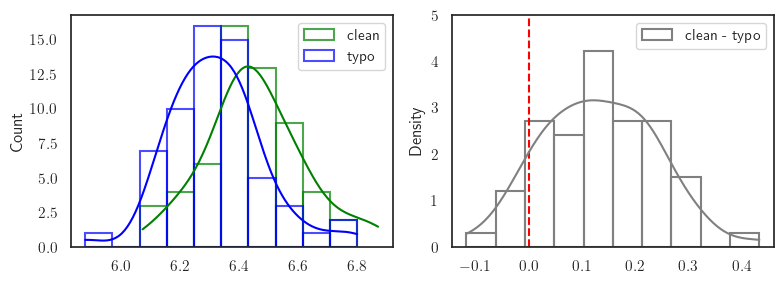

In [153]:


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
bins = 10

_, edges = np.histogram(dl_typo, bins)

sns.histplot(x=dl_clean, ax=ax[0], label="clean", kde=True, fill=False, color="green", bins=edges, alpha=0.7)
sns.histplot(x=dl_typo, ax=ax[0], label="typo", kde=True, fill=False, color="blue", bins=edges, alpha=0.7)

ax[0].legend()


# ax[1].hist(diff, alpha=0.7)
ax[1].vlines(0, 0, 5, linestyles="dashed", color="red")
ax[1].set_ylim(0, 5)

sns.histplot(x=diff, ax=ax[1], stat="density", kde=True, fill=False, color="gray", bins=bins, label="clean - typo")
ax[1].legend()
plt.tight_layout()
#plt.show()
plt.savefig("./figures/typo_clean.pdf", format="pdf")

In [127]:
dl_clean

[0.94035595431676,
 0.3679537769792763,
 0.6194184261704168,
 0.5303833194499329,
 0.33960866264722295,
 0.45587314740937224,
 0.7372090753811747,
 0.47386836788099873,
 0.5885017838669218,
 0.8050976258381816,
 0.7845248473907384,
 0.5550427025998482,
 0.8421036419899515,
 0.892531892473679,
 0.2985623495315408,
 0.7038526300372241,
 0.7524194725114992,
 0.50628855493613,
 0.26462022272743835,
 0.6223316162156192,
 0.8235003912143894,
 0.8217960025841924,
 0.7856329503176064,
 0.538054873047482,
 0.9320095402047682,
 0.8654994761511731,
 0.6654330933243744,
 0.2836239379909833,
 0.7846945255067925,
 0.3286774506758567,
 0.7012465948435932,
 0.2713288101595817,
 0.2259617509448683,
 0.789517465306679,
 0.7179017021561757,
 0.5966951197831223,
 0.7262287617954056,
 0.8379265567847838,
 0.5768265735837366,
 0.435598227674263,
 0.7964270244545636,
 0.6440744967492387,
 0.786162197427978,
 0.5692391525124092,
 0.7630946912803435,
 0.945563695734425,
 0.3458361625272789,
 0.5562152746439841

In [126]:
dl_typo

[0.5822525482929054,
 0.2950521386928532,
 0.0,
 0.0,
 0.0,
 0.02332713380146187,
 0.0,
 0.2950521386928532,
 0.5826411260327944,
 0.7123406089478114,
 0.6811829912441201,
 0.0,
 0.6320327212297299,
 0.0,
 0.0,
 0.26696586929063,
 0.6454553587107735,
 0.3266490440479474,
 0.17554440492323456,
 0.4729814801758033,
 0.0,
 0.4578364248639806,
 0.9225698816956198,
 0.17504020290384825,
 0.0,
 0.3222722491219546,
 0.35289446391837986,
 0.2736991811496751,
 0.6492234872423333,
 0.0,
 0.4065747172222398,
 0.422827336014388,
 0.0,
 0.7739745466474057,
 0.6787496778246955,
 0.26053926624952495,
 0.0,
 0.22486036416572236,
 0.0,
 0.7554996977432099,
 0.0,
 0.0,
 0.0,
 0.4007702828282184,
 0.6936634693435663,
 0.0,
 0.3120935937109055,
 0.1622704438838536,
 0.2600999199660596,
 0.17957728914039015,
 0.0,
 0.675520586886956,
 0.06943122193677725,
 0.64283842670705,
 0.15738556887491575,
 0.6835381846158709,
 0.026899541414986676,
 0.512652365179441,
 0.9292363597887484,
 0.6647872671150953]

## QPP stuff


/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


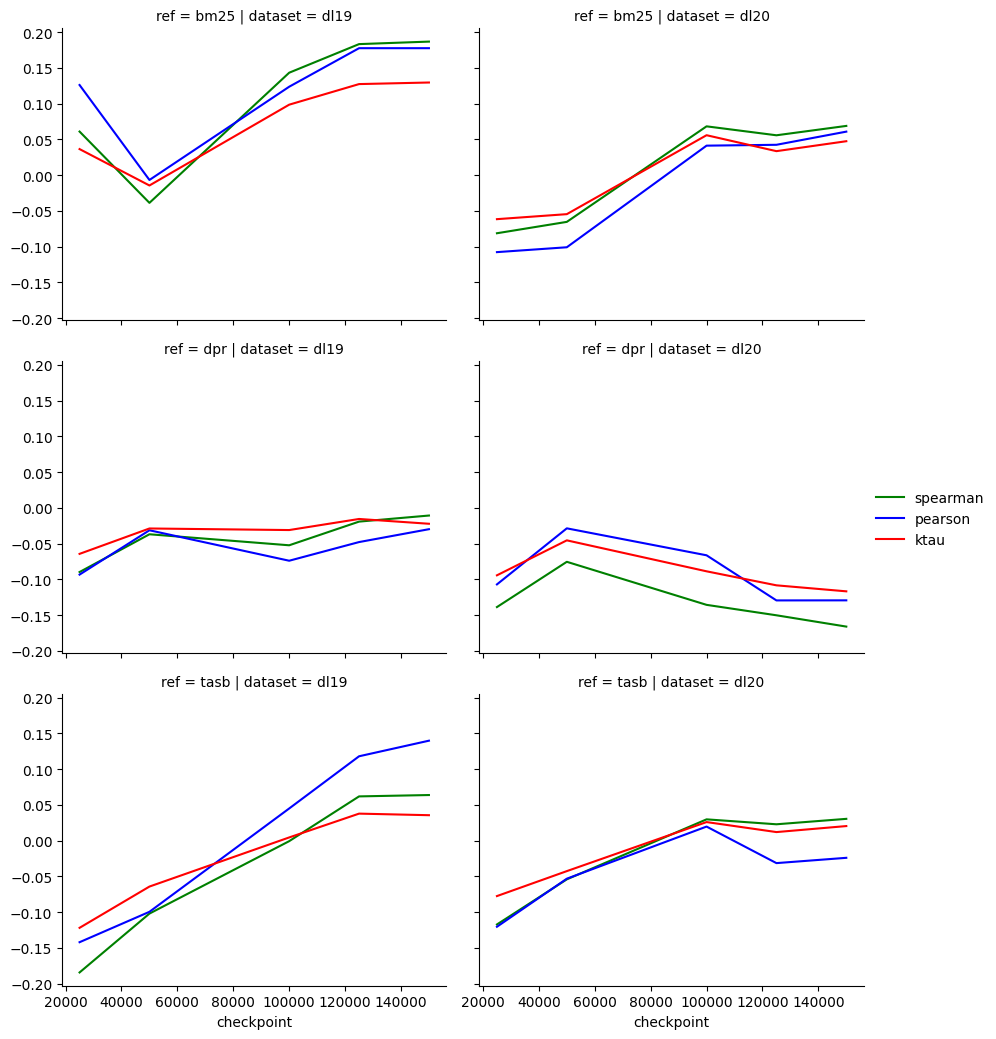

In [62]:
g = sns.FacetGrid(df, col="dataset", row="ref", height=3.5, aspect=1.3, sharey=True)
g.map(sns.lineplot, "checkpoint", "spearman", data=df, color="green", label="spearman")
g.map(sns.lineplot, "checkpoint", "pearson", data=df, color="blue", label="pearson")
g.map(sns.lineplot, "checkpoint", "ktau", data=df, color="red", label="ktau")
g.set_ylabels("")
g.add_legend()
g.savefig("figures/qpp_checkpoint.png")

In [70]:
sel={"MVRL (ND, LV)": 14, "MVRL-ND-TASB-Logvar-2GPU": 28, "MVRL-(ND, LV BZ-128)": 128, "MVRL-(ND, LV BZ-256)": 256, "MVRL-(ND, LV BZ-512)": 512}
bz_df = all_res_df[all_res_df.model.apply(lambda _: _ in sel)].copy()
bz_df["bz"] = bz_df.model.apply(lambda _: sel[_])
bz_df_ = []
for row in bz_df.to_dict("records"):
    for col in bz_df.columns:
        if col in {"model", "bz"}:
            continue
        bz_df_.append({
            "model": row["model"],
            "bz": row["bz"],
            "dataset": col.split("_")[0],
            "metric": "_".join(col.split("_")[1:]),
            "value": row[col]
        })
bz_df = pd.DataFrame(bz_df_)


/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


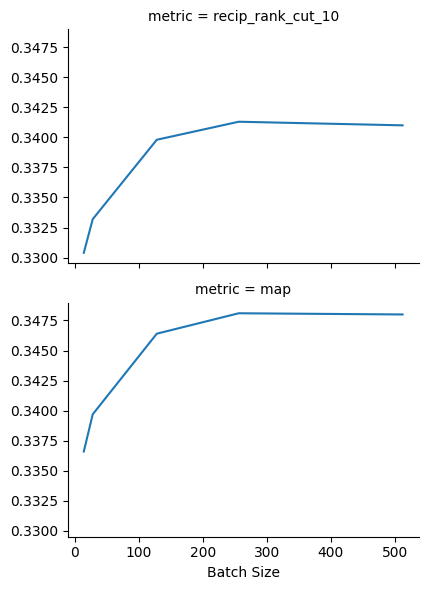

In [67]:
# plt.figure()
msm_bz_df = bz_df.query("dataset == 'dev'")
g = sns.FacetGrid(msm_bz_df, row="metric", aspect=1.5)
g.map(sns.lineplot, "bz", "value", data=bz_df)
g.set_ylabels("")
g.set_xlabels("Batch Size")
#plt.suptitle("MSMARCO Dev", y=0, x=0.57)
g.add_legend()
g.savefig("figures/msm_bz.svg")
# sns.lineplot(x="bz", y="dev_map", data=bz_df)
# sns.lineplot(x="bz", y="dev_recip_rank_cut_10", data=bz_df)
# plt.show()

/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


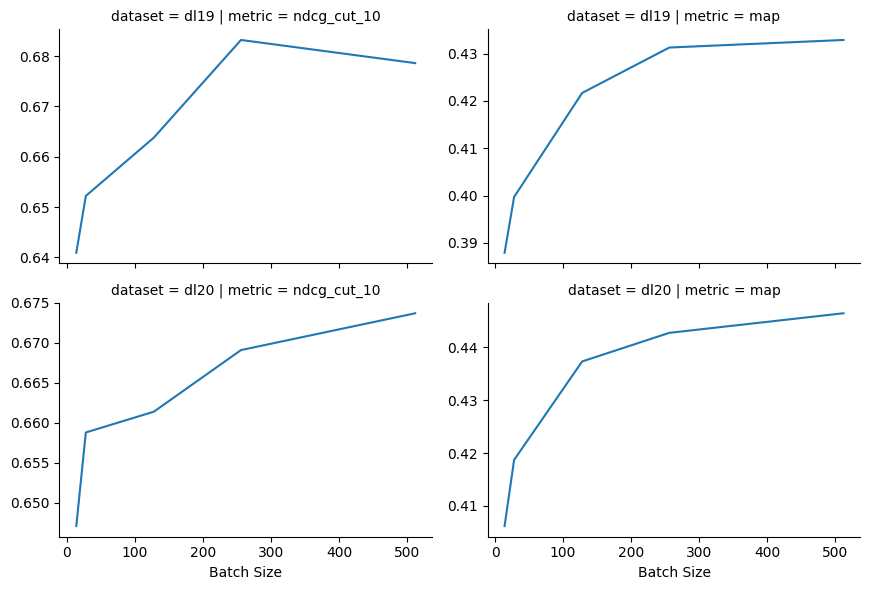

In [68]:
dl_bz_df = bz_df.query("dataset == 'dl19' or dataset == 'dl20'")
g = sns.FacetGrid(dl_bz_df, col="metric", row="dataset", aspect=1.5, sharey=False)
g.map(sns.lineplot, "bz", "value", data=dl_bz_df)
g.set_ylabels("")
g.set_xlabels("Batch Size")
#plt.suptitle("DL19/20", y=0, x=0.55)
g.savefig("figures/dl1920_bz.svg")

/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


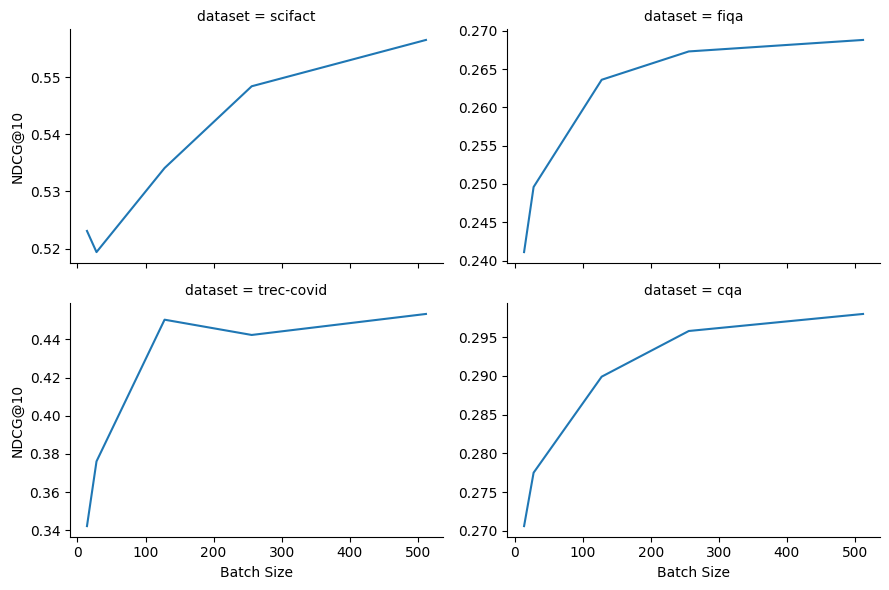

In [69]:
zs_bz_df = bz_df.query("dataset != 'dl19' and dataset != 'dl20' and dataset != 'dev'")
g = sns.FacetGrid(zs_bz_df, col="dataset", col_wrap=2, aspect=1.5, sharey=False)
g.map(sns.lineplot, "bz", "value", data=zs_bz_df)
g.set_ylabels("NDCG@10")
g.set_xlabels("Batch Size")
g.savefig("figures/zs_bz.svg")

### Dataset statistics


In [5]:
import datasets
from transformers import AutoConfig, AutoTokenizer

In [36]:
def get_statistics(name, corpus, query, tokenizer_name="distilbert-base-uncased"):

    def count_tokens(dataset, field):
        counts = dataset.map(lambda _: {"n_toks": len(tokenizer(_[field])["input_ids"])})
        return np.sum(counts["n_toks"])
        
    
    if "beir" in corpus:
        corpus = datasets.load_dataset("Tevatron/beir-corpus", corpus.split(":")[-1], split="train")
        query = datasets.load_dataset("Tevatron/beir", query.split(":")[-1], split="test")
    else:
        corpus = datasets.load_dataset(corpus, split="train")
        try:
            query = datasets.load_dataset(query)
        except:
            _ = query.split("/")
            query = datasets.load_dataset("/".join(_[:2]), split=_[-1])
        
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    return {
        "name": name,
        "nQ": len(query),
        "nD": len(corpus),
        "nQToks": count_tokens(query, "query"),
        "nDToks": count_tokens(corpus, "text")
    }


DATASETS = {
    "MSMARCO": ("Tevatron/msmarco-passage-corpus", "Tevatron/msmarco-passage/dev"),
    "TREC-DL19": ("Tevatron/msmarco-passage-corpus", "Tevatron/msmarco-passage/dl19"),
    "TREC-DL20": ("Tevatron/msmarco-passage-corpus", "Tevatron/msmarco-passage/dl20"),
    "Scifact": ("Tevatron/scifact-corpus", "Tevatron/scifact/dev"),
}
CQA = ["cqadupstack-android", "cqadupstack-english", "cqadupstack-gaming", "cqadupstack-gis",
       "cqadupstack-wordpress", "cqadupstack-physics", "cqadupstack-programmers",
       "cqadupstack-stats", "cqadupstack-tex", "cqadupstack-unix",
       "cqadupstack-webmasters", "cqadupstack-wordpress", "cqadupstack-mathematica"]

for d in ["fiqa", "trec-covid"] + CQA:
    DATASETS[d] = (f"Tevatron/beir-corpus:{d}", f"Tevatron/beir:{d}")


d_stats = []

for d, (corpus, query) in DATASETS.items():
    d_stats.append(get_statistics(d, corpus, query))

d_stats = pd.DataFrame(d_stats)
row = d_stats[d_stats["name"].apply(lambda _: _.startswith("cqa"))].sum()
row = row.to_dict()
row["name"] = "cqadupstack"
d_stats = pd.concat([d_stats[d_stats["name"].apply(lambda _: not _.startswith("cqa"))], pd.DataFrame([row])])

Reusing dataset msmarco-passage-corpus (/Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage-corpus/default/0.0.1/3d8add51914a7d2b589d09e37f4cd9646ebe4a3bad6d59b4e3702cfcc9941f23)
Reusing dataset msmarco-passage (/Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage/default/0.0.1/300947ae554083632b487251f17ce2100425fd1135048532fb20afa1d66e9e62)
Loading cached processed dataset at /Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage/default/0.0.1/300947ae554083632b487251f17ce2100425fd1135048532fb20afa1d66e9e62/cache-42e7728fe43ace96.arrow
Loading cached processed dataset at /Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage-corpus/default/0.0.1/3d8add51914a7d2b589d09e37f4cd9646ebe4a3bad6d59b4e3702cfcc9941f23/cache-9e328a5f004a0087.arrow
Reusing dataset msmarco-passage-corpus (/Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage-corpus/default/0.0.1/3d8add51914a7d2b589d09e37f4cd9646ebe4a3bad6d59b4e3702cfcc9941f23)
Reusing 

In [39]:
d_stats["avgQLen"] = d_stats["nQToks"] / d_stats["nQ"]
d_stats["avgDLen"] = d_stats["nDToks"] / d_stats["nD"]
d_stats

,name,nQ,nD,nQToks,nDToks,avgQLen,avgDLen
0,MSMARCO,6980,8841823,62958,680584022,9.019771,76.973269
1,TREC-DL19,43,8841823,388,680584022,9.023256,76.973269
2,TREC-DL20,54,8841823,498,680584022,9.222222,76.973269
3,Scifact,300,5183,6853,1636015,22.843333,315.650203
4,fiqa,648,57638,10103,10208682,15.591049,177.117214
5,trec-covid,50,171332,902,38511584,18.040000,224.777531
0,cqadupstack,13145,457199,178157,113720074,13.553214,248.732114


/var/folders/dv/nvf6gnxn4tn8cxsbt18y6x3m0000gn/T/ipykernel_92343/662419167.py:15: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(x, y, z, color="Blues")


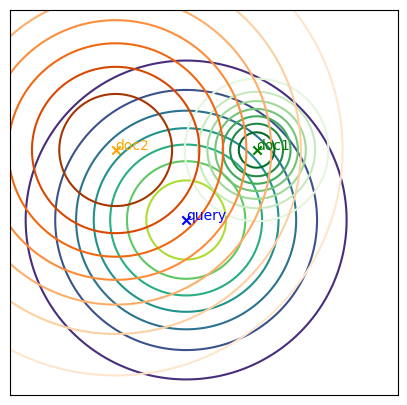

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

x, y = np.mgrid[-10:10:.1, -10:10:.1]
query = multivariate_normal([0, 0], [[5, 0], [0, 5.0]])
docrel = multivariate_normal([2, 2], [[1, 0], [0, 1.0]])
doc_irrel = multivariate_normal([-2, 2], [[10, 0], [0, 10.0]])


plt.figure(figsize=(5, 5))

data = np.dstack((x, y))
z = query.pdf(data)
plt.contour(x, y, z, color="Blues")
plt.text(0,0, "query", color="blue")
plt.scatter([0], [0], marker="x", color="blue")

z = docrel.pdf(data)
plt.contour(x, y, z, cmap="Greens")
plt.text(2,2, "doc1", color="green")
plt.scatter([2], [2], marker="x", color="green")


z = doc_irrel.pdf(data)
plt.contour(x, y, z, cmap="Oranges")
plt.text(-2,2, "doc2", color="orange")
plt.scatter([-2], [2], marker="x", color="orange")

plt.yticks([])
plt.xticks([])

plt.ylim((-5, 6))
plt.xlim((-5, 6))

#plt.show()
plt.savefig("ex_mult_qd.png", dpi=600)

In [220]:
-10 - 7.5

-17.5

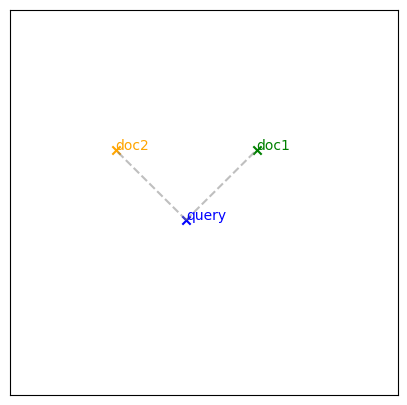

In [241]:

x, y = np.mgrid[-10:10:.1, -10:10:.1]
query = multivariate_normal([0, 0], [[5, 0], [0, 5.0]])
docrel = multivariate_normal([2, 2], [[1, 0], [0, 1.0]])
doc_irrel = multivariate_normal([-2, 2], [[10, 0], [0, 10.0]])


plt.figure(figsize=(5, 5))

data = np.dstack((x, y))
z = query.pdf(data)
#plt.contour(x, y, z, color="Blues")
plt.text(0,0, "query", color="blue")
plt.scatter([0], [0], marker="x", color="blue")

z = docrel.pdf(data)
#plt.contour(x, y, z, cmap="Greens")
plt.text(2,2, "doc1", color="green")
plt.scatter([2], [2], marker="x", color="green")


z = doc_irrel.pdf(data)
#plt.contour(x, y, z, cmap="Oranges")
plt.text(-2,2, "doc2", color="orange")
plt.scatter([-2], [2], marker="x", color="orange")


plt.yticks([])
plt.xticks([])


plt.plot([0, -2], [0, 2], linestyle="--", color="gray", alpha=.5)
plt.plot([0, 2], [0, 2], linestyle="--", color="gray", alpha=.5)

plt.ylim((-5, 6))
plt.xlim((-5, 6))

#plt.show()
plt.savefig("ex_qd.png", dpi=600)

In [270]:
d = np.diag([1, 2])
d

array([[1, 0],
       [0, 2]])

In [265]:
q = np.diag([2, 1])
q

array([[2, 0],
       [0, 1]])

[['2/1' '0']
 ['0' '1/2']]


In [266]:
np.trace((1/(d+1e-10)) @ q)

2.499999999775

In [263]:
(q.diagonal()/d.diagonal()).sum()

4.333333333333333

In [ ]:
d.diagonal()

In [ ]:
print(np.array([
    ["2/1", "0"],
    ["0", "1/2"]]
))